  # Autoencoder Training - Baseline mode

# Setup

In [1]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        # print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from typing import Dict, List, Tuple


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torchinfo import summary
import wandb


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-BASE-MAIN.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.set_num_threads(4)  ## <--- limit to ~ 2 CPUs
torch.get_num_threads()

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']
2.2.2


In [3]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace
import snnl.utils as utils

# from snnl.utils import load_model, save_model, import_results, export_results
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import display_model_summary, define_autoencoder_model, init_resume_training
from snnl.utils import save_checkpoint_v5, load_checkpoint_v5
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict
from snnl.utils import define_autoencoder_model, init_resume_training

from snnl.models import Model
from snnl.models import DNN 
from snnl.models import Autoencoder
from snnl.losses import SNNLoss

In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
# logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-09-04 23:49:22,504 - __main__ - INFO: -  Excution started : 2024_09_04_23:49:22 
2024-09-04 23:49:22,505 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 7
2024-09-04 23:49:22,506 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.1  


### main(args)

In [6]:
GPU_ID = 1
LATENT_DIM    = 150
HIDDEN_1      = 512
EPOCHS        = 200
COMPOUNDS_PER_BATCH = 200
LEARNING_RATE = 1.00e-04
TEMP          = 1.00
TEMP_LR       = 0.00   ##1.0e-05
ADAM_WEIGHT_DECAY = 0.001
# LOSS_FACTOR   = 134.0
SNNL_FACTOR   = 3.0
# CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
# RUN_ID        = "jzt6ecjz"
# print(CHECKPT)

In [7]:
# if __name__ == "__main__":
cli_args = f" --runmode             baseline" \
            f" --configuration      hyperparameters/ae_baseline_{LATENT_DIM:03d}_{HIDDEN_1}_cpb.yaml" \
            f" --epochs             {EPOCHS} " \
            f" --single_loss        "\
            f" --prim_opt           "\
            f" --adam_wd            {ADAM_WEIGHT_DECAY}"\
            f" --lr                 {LEARNING_RATE} "\
            f" --cpb                {COMPOUNDS_PER_BATCH}"\
            f" --seed               4321"\
            f" --wandb              "\
            f" --gpu_id             {GPU_ID} "  \
            f" "



# f" --ckpt               AE_base_scpb200_150Ltnt_512_20240830_2302_LAST_ep_600.pt "\
# f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
# f" --run_id             7jgfgufy " \
# f" --seed               4321 " 
# f" --exp_title           snglOpt-050Ltnt_512_sig "
# f" --runmode            snnl" \

cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
args.ckpt

Namespace(configuration='hyperparameters/ae_baseline_150_512_cpb.yaml', ckpt=None, cpb=200, exp_title=None, epochs=200, gpu_id=1, learning_rate=0.0001, exp_id=None, runmode='baseline', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=False, anneal_patience=15, use_single_loss=True, temperature=None, adam_weight_decay=0.001, loss_factor=None, snnl_factor=None, temperatureLR=None, WANDB_ACTIVE=True)

2024-09-04 23:49:27,012 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [hyperparameters/ae_baseline_150_512_cpb.yaml]
2024-09-04 23:49:27,013 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [None]
2024-09-04 23:49:27,014 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [200]
2024-09-04 23:49:27,014 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-09-04 23:49:27,015 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [200]
2024-09-04 23:49:27,016 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [1]
2024-09-04 23:49:27,017 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [0.0001]
2024-09-04 23:49:27,017 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    : [None]
2024-09-04 23:49:27,018 - snnl.utils.utils_

In [8]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  15
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  200
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_star

In [9]:
### Set random seed and gpu device

set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device(verbose=True)
    args.current_device = set_device(args.gpu_id)
    print(f" args.current_device is : {args.current_device}")

 device: 0   Quadro GV100                   :  free: 33,423,949,824 B   (31.13 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 33,012,908,032 B   (30.75 GB)    total: 34,069,872,640 B   (31.73 GB)


2024-09-04 23:49:29,877 - snnl.utils.utils_ptsnnl - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-09-04 23:49:29,878 - snnl.utils.utils_ptsnnl - INFO: -  Switched to: Quadro GV100 - 1


 device: 2   NVIDIA TITAN Xp                :  free: 12,252,217,344 B   (11.41 GB)    total: 12,774,539,264 B   (11.90 GB)
 args.current_device is : cuda:1


 ### WandB Setup

In [10]:
wandb_run = utils.setup_wandb(args)

2024-09-04 23:49:32,008 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Autoencoder_dev.ipynb.


None, AE_20240904_2349, CellPainting_Profiles


wandb: Currently logged in as: kbardool. Use `wandb login --relogin` to force relogin


2024-09-04 23:49:40,727 - snnl.utils.utils_notebook - INFO: -  Experiment Name  : AE_20240904_2349
2024-09-04 23:49:40,729 - snnl.utils.utils_notebook - INFO: -  Experiment Date  : 20240904_2349
2024-09-04 23:49:40,731 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
2024-09-04 23:49:40,733 - snnl.utils.utils_notebook - INFO: - WANDB_ACTIVE     : True
2024-09-04 23:49:40,734 - snnl.utils.utils_notebook - INFO: - Project Name     : CellPainting_Profiles
2024-09-04 23:49:40,735 - snnl.utils.utils_notebook - INFO: - Experiment Id    : 0pvjjh3a
2024-09-04 23:49:40,736 - snnl.utils.utils_notebook - INFO: - Experiment Name  : AE_20240904_2349
2024-09-04 23:49:40,738 - snnl.utils.utils_notebook - INFO: - Experiment Date  : 20240904_2349
2024-09-04 23:49:40,739 - snnl.utils.utils_notebook - INFO: - Experiment Title : scpb200_150Ltnt_512
2024-09-04 23:49:40,740 - snnl.utils.utils_notebook - INFO: - Experiment Notes : AE baseline - snglOpt, 150 dim latent, 512 Midlayer, 

In [ ]:
# if args.WANDB_ACTIVE:
#     wandb_run.finish()
#     args.WANDB_ACTIVE = False

  ### Define dataset and dataloaders

In [11]:
# args.cellpainting_args['train_start'] = 0
# args.cellpainting_args['train_end']   = 240_000
# args.cellpainting_args

#### Load CellPainting Dataset
data_loaders = utils.build_dataloaders(args, data = ['train', 'val'])

2024-09-04 23:51:16,693 - root - INFO: -  load cellpainting
2024-09-04 23:51:16,695 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-09-04 23:51:16,696 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-09-04 23:51:16,697 - snnl.utils.dataloader - INFO: -  type    :  train
2024-09-04 23:51:16,698 - snnl.utils.dataloader - INFO: -  start   :  0
2024-09-04 23:51:16,699 - snnl.utils.dataloader - INFO: -  end     :  240000
2024-09-04 23:51:16,700 - snnl.utils.dataloader - INFO: -  numrows :  240000
2024-09-04 23:51:16,701 - snnl.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-09-04 23:51:16,702 - snnl.utils.dataloader - INFO: -  batch_size  :  1
2024-09-04 23:51:16,703 - snnl.utils.dataloader - INFO: -  sample_size :  3
2024-09-04 23:51:16,704 - snnl.utils.dataloader - INFO: -  compounds_per_batch :  200
2024-09-04 23:51:16,

 load cellpainting
 Dataset size: 240000   rows per batch: 600
 Dataset size: 24000   rows per batch: 600


# Define autoencoder model

## Override arguments

In [12]:
# args.temperature   = 0.0
# args.loss_factor   = 1.0        ## 2.0e+00
# args.snnl_factor   = 0.0       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 0.0e-04    ## 1e-4
print(f"   runmode                  {args.runmode}")
print(f"   embedding_layer          {args.embedding_layer}")
print(f"   Latent dim               {args.code_units}")
print(f"   loss_factor              {args.loss_factor}")
print(f"   snnl_factor              {args.snnl_factor}")
print(f"   temperature              {args.temperature}")
print(f"   learning_rate            {args.learning_rate}")
print(f"   temperatureLR:           {args.temperatureLR}")
print(f"   use_annealing:           {args.use_annealing}")
print(f"   anneal_patience:         {args.anneal_patience}")
print(f"   use Primary Optimizer:   {args.use_prim_optimizer}")
print(f"   use Primary Scheduler:   {args.use_prim_scheduler}")

   runmode                  baseline
   embedding_layer          4
   Latent dim               150
   loss_factor              1.0
   snnl_factor              0.0
   temperature              0.0
   learning_rate            0.0001
   temperatureLR:           0.0
   use_annealing:           False
   anneal_patience:         15
   use Primary Optimizer:   True
   use Primary Scheduler:   True


## Define Model

In [13]:
### Define Model
args.runmode
model = define_autoencoder_model(args, verbose = True)
model.device


'baseline'

2024-09-04 23:51:21,498 - snnl.utils.utils_notebook - INFO: - Defining model in baseline mode
2024-09-04 23:51:21,501 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-04 23:51:21,541 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-04 23:51:21,542 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-04 23:51:21,549 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-04 23:51:21,550 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-09-04 23:51:21,552 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input: 

 EMBEDDING LAYER: 4
 Device cuda:1 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              autoencoding
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'autoencoding' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         False
    Model_init()_    -- temperature :      0
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : autoencoding
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linear', 'linear', 'relu', 'linear', 'relu', 'linear']

'cuda:1'

In [14]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  15
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  200
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_star

## Resume from model checkpoint (if args.ckpt is not None)

In [15]:
args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5
# print(f" Checkpoint File :  {args.ckpt}")

model = init_resume_training(model, args)

if args.WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
    wandb.config.update(args)

2024-09-04 23:51:25,115 - root - INFO: -  INITIALIZE TRAINING - Run 200 epochs: epoch 1 to 200 


In [16]:
display_model_hyperparameters(model)

Model Hyperparameters
----------------------
 Model device           : cuda:1
 Model epoch/batch      : -1 / -1
 Model embedding_layer  : 4
 loss_factor            : 1.0
 monitor_grads_layer    : None
 Use Single Loss        : True
 Use Prim Optimizer     : True
 Use Prim Scheduler     : True
 Main Optimizer Params  : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.001
)
 Scheduler              : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f35edf8b310> 
    factor: 0.5  
    min_lrs: [0]  
    patience: 50  
    verbose: False  
    cooldown: 10  
    cooldown_counter: 0  
    mode: min  
    threshold: 1e-06  
    threshold_mode: rel  
    best: inf  
    num_bad_epochs: 0  
    mode_worse: inf  
    eps: 1e-08  
    last_epoch: 0  

 Use snnl               : False

 Use Temp Optimizer     : False
 Use 

In [17]:
# display_model_state_dict(model, 'test')
# display_model_parameters(model, 'title')
# display_model_gradients(model, 'test')
# display_model_hyperparameters(model)
#
# for k,v in model.__dict__.items():
#     if k == 'training_history':
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v.keys()} ")
#     else:
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v} ")
#
# print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}")
# for k,v in model.optimizers.items():
#     print(k, v)
#
# for k,v in enumerate(model.optimizers['prim'].param_groups[0]['params']):
#     print(f" {k}, {v.shape}")
#
# model.schedulers['prim'].state_dict()
# model.optimizers['prim'].state_dict()
# model.display_values('test')
# model.display_gradients('test')
# model.optimizers['prim'].state_dict()

# Autoencoder Fit

In [18]:
#
#  Running Training Loop
#
logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-09-04 23:51:29,810 - __main__ - INFO: -  Experiment run id:  0pvjjh3a
2024-09-04 23:51:29,811 - __main__ - INFO: -  Experiment Name  :  AE_20240904_2349 
2024-09-04 23:51:29,812 - __main__ - INFO: -  Experiment Date  :  20240904_2349 
2024-09-04 23:51:29,813 - __main__ - INFO: -  Experiment Title :  scpb200_150Ltnt_512 
2024-09-04 23:51:29,814 - __main__ - INFO: -  Experiment Notes :  AE baseline - snglOpt, 150 dim latent, 512 Midlayer, 200 cpb


In [19]:
# model.starting_epoch = 0
# model.ending_epoch = 100
# model.starting_epoch, model.ending_epoch = 0, 600
# model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")


 2024-09-04 23:51:31  epoch    1 of  200


In [20]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")


 2024-09-04 23:51:33  Start: epoch    1 of  200
                                                                                                                                                                           

2024-09-04 23:53:53,213 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 1


  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
23:53:53  1 /200  |   0.8022     0.8022     0.0000 |   0.000000   0.0000e+00 | -11.2477     1           |   0.4903     0.4903     0.0000 |  -3.2587     1             |  1.000e-04   0.000e+00 |
23:56:14  2 /200  |   0.4024     0.4024     0.0000 |   0.000000   0.0000e+00 |  -1.7701     2           |   0.3328     0.3328     0.0000 |  -0.4671     2             |  1.000e-04   0.000e+00 |


2024-09-04 23:56:14,953 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 2


23:58:46  3 /200  |   0.3052     0.3052     0.0000 |   0.000000   0.0000e+00 |  -0.0475     3           |   0.2759     0.2759     0.0000 |   0.2103     3             |  1.000e-04   0.000e+00 |


2024-09-04 23:58:46,926 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 3


00:01:23  4 /200  |   0.2650     0.2650     0.0000 |   0.000000   0.0000e+00 |   0.4125     4           |   0.2501     0.2501     0.0000 |   0.4274     4             |  1.000e-04   0.000e+00 |


2024-09-05 00:01:23,701 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 4


00:03:59  5 /200  |   0.2458     0.2458     0.0000 |   0.000000   0.0000e+00 |   0.5795     5           |   0.2370     0.2370     0.0000 |   0.5170     5             |  1.000e-04   0.000e+00 |


2024-09-05 00:03:59,780 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 5


00:06:36  6 /200  |   0.2361     0.2361     0.0000 |   0.000000   0.0000e+00 |   0.6332     6           |   0.2304     0.2304     0.0000 |   0.5686     6             |  1.000e-04   0.000e+00 |


2024-09-05 00:06:36,447 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 6


00:09:10  7 /200  |   0.2307     0.2307     0.0000 |   0.000000   0.0000e+00 |   0.6535     7           |   0.2260     0.2260     0.0000 |   0.5887     7             |  1.000e-04   0.000e+00 |


2024-09-05 00:09:11,184 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 7


00:11:43  8 /200  |   0.2271     0.2271     0.0000 |   0.000000   0.0000e+00 |   0.6667     8           |   0.2233     0.2233     0.0000 |   0.6049     8             |  1.000e-04   0.000e+00 |


2024-09-05 00:11:43,767 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 8


00:14:16  9 /200  |   0.2252     0.2252     0.0000 |   0.000000   0.0000e+00 |   0.6722     9           |   0.2219     0.2219     0.0000 |   0.6197     9             |  1.000e-04   0.000e+00 |


2024-09-05 00:14:16,788 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 9


00:16:48 10 /200  |   0.2242     0.2242     0.0000 |   0.000000   0.0000e+00 |   0.6752    10           |   0.2213     0.2213     0.0000 |   0.6293    10             |  1.000e-04   0.000e+00 |


2024-09-05 00:16:48,511 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 10


00:19:19 11 /200  |   0.2237     0.2237     0.0000 |   0.000000   0.0000e+00 |   0.6777    11           |   0.2208     0.2208     0.0000 |   0.6366    11             |  1.000e-04   0.000e+00 |


2024-09-05 00:19:19,433 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 11


00:21:51 12 /200  |   0.2234     0.2234     0.0000 |   0.000000   0.0000e+00 |   0.6789    12           |   0.2206     0.2206     0.0000 |   0.6424    12             |  1.000e-04   0.000e+00 |


2024-09-05 00:21:51,391 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 12


00:24:20 13 /200  |   0.2231     0.2231     0.0000 |   0.000000   0.0000e+00 |   0.6793    13           |   0.2203     0.2203     0.0000 |   0.6468    13             |  1.000e-04   0.000e+00 |


2024-09-05 00:24:20,924 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 13


00:26:51 14 /200  |   0.2229     0.2229     0.0000 |   0.000000   0.0000e+00 |   0.6795    14           |   0.2201     0.2201     0.0000 |   0.6494    14             |  1.000e-04   0.000e+00 |


2024-09-05 00:26:51,683 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 14


00:29:23 15 /200  |   0.2227     0.2227     0.0000 |   0.000000   0.0000e+00 |   0.6795    15           |   0.2199     0.2199     0.0000 |   0.6518    15             |  1.000e-04   0.000e+00 |


2024-09-05 00:29:23,815 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 15


00:31:55 16 /200  |   0.2225     0.2225     0.0000 |   0.000000   0.0000e+00 |   0.6797    16           |   0.2198     0.2198     0.0000 |   0.6537    16             |  1.000e-04   0.000e+00 |


2024-09-05 00:31:55,450 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 16


00:34:27 17 /200  |   0.2223     0.2223     0.0000 |   0.000000   0.0000e+00 |   0.6799    17           |   0.2195     0.2195     0.0000 |   0.6544    17             |  1.000e-04   0.000e+00 |


2024-09-05 00:34:28,315 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 17


00:37:00 18 /200  |   0.2221     0.2221     0.0000 |   0.000000   0.0000e+00 |   0.6801    18           |   0.2194     0.2194     0.0000 |   0.6550    18             |  1.000e-04   0.000e+00 |


2024-09-05 00:37:00,396 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 18


00:39:32 19 /200  |   0.2220     0.2220     0.0000 |   0.000000   0.0000e+00 |   0.6804    19           |   0.2193     0.2193     0.0000 |   0.6556    19             |  1.000e-04   0.000e+00 |


2024-09-05 00:39:32,905 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 19


00:42:04 20 /200  |   0.2218     0.2218     0.0000 |   0.000000   0.0000e+00 |   0.6805    20           |   0.2191     0.2191     0.0000 |   0.6564    20             |  1.000e-04   0.000e+00 |


2024-09-05 00:42:04,699 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 20


00:44:35 21 /200  |   0.2216     0.2216     0.0000 |   0.000000   0.0000e+00 |   0.6807    21           |   0.2190     0.2190     0.0000 |   0.6564    20             |  1.000e-04   0.000e+00 |
00:47:05 22 /200  |   0.2214     0.2214     0.0000 |   0.000000   0.0000e+00 |   0.6808    22           |   0.2188     0.2188     0.0000 |   0.6571    22             |  1.000e-04   0.000e+00 |


2024-09-05 00:47:06,204 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 22


00:49:37 23 /200  |   0.2213     0.2213     0.0000 |   0.000000   0.0000e+00 |   0.6811    23           |   0.2187     0.2187     0.0000 |   0.6575    23             |  1.000e-04   0.000e+00 |


2024-09-05 00:49:37,532 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 23


00:52:08 24 /200  |   0.2211     0.2211     0.0000 |   0.000000   0.0000e+00 |   0.6813    24           |   0.2186     0.2186     0.0000 |   0.6579    24             |  1.000e-04   0.000e+00 |


2024-09-05 00:52:09,169 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 24


00:54:39 25 /200  |   0.2210     0.2210     0.0000 |   0.000000   0.0000e+00 |   0.6813    24           |   0.2184     0.2184     0.0000 |   0.6579    25             |  1.000e-04   0.000e+00 |


2024-09-05 00:54:40,132 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 25


00:57:11 26 /200  |   0.2209     0.2209     0.0000 |   0.000000   0.0000e+00 |   0.6817    26           |   0.2183     0.2183     0.0000 |   0.6588    26             |  1.000e-04   0.000e+00 |


2024-09-05 00:57:11,897 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 26


00:59:43 27 /200  |   0.2208     0.2208     0.0000 |   0.000000   0.0000e+00 |   0.6813    26           |   0.2182     0.2182     0.0000 |   0.6585    26             |  1.000e-04   0.000e+00 |
01:02:15 28 /200  |   0.2206     0.2206     0.0000 |   0.000000   0.0000e+00 |   0.6815    26           |   0.2181     0.2181     0.0000 |   0.6588    28             |  1.000e-04   0.000e+00 |


2024-09-05 01:02:15,956 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 28


01:04:47 29 /200  |   0.2205     0.2205     0.0000 |   0.000000   0.0000e+00 |   0.6823    29           |   0.2180     0.2180     0.0000 |   0.6590    29             |  1.000e-04   0.000e+00 |


2024-09-05 01:04:47,688 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 29


01:07:19 30 /200  |   0.2204     0.2204     0.0000 |   0.000000   0.0000e+00 |   0.6818    29           |   0.2179     0.2179     0.0000 |   0.6593    30             |  1.000e-04   0.000e+00 |


2024-09-05 01:07:19,873 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 30


01:09:50 31 /200  |   0.2203     0.2203     0.0000 |   0.000000   0.0000e+00 |   0.6823    31           |   0.2177     0.2177     0.0000 |   0.6586    30             |  1.000e-04   0.000e+00 |
01:12:19 32 /200  |   0.2202     0.2202     0.0000 |   0.000000   0.0000e+00 |   0.6820    31           |   0.2177     0.2177     0.0000 |   0.6588    30             |  1.000e-04   0.000e+00 |
01:14:47 33 /200  |   0.2201     0.2201     0.0000 |   0.000000   0.0000e+00 |   0.6818    31           |   0.2176     0.2176     0.0000 |   0.6594    33             |  1.000e-04   0.000e+00 |


2024-09-05 01:14:47,923 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 33


01:17:15 34 /200  |   0.2200     0.2200     0.0000 |   0.000000   0.0000e+00 |   0.6821    31           |   0.2175     0.2175     0.0000 |   0.6594    33             |  1.000e-04   0.000e+00 |
01:19:42 35 /200  |   0.2199     0.2199     0.0000 |   0.000000   0.0000e+00 |   0.6822    31           |   0.2174     0.2174     0.0000 |   0.6577    33             |  1.000e-04   0.000e+00 |
01:22:10 36 /200  |   0.2198     0.2198     0.0000 |   0.000000   0.0000e+00 |   0.6822    31           |   0.2173     0.2173     0.0000 |   0.6594    36             |  1.000e-04   0.000e+00 |


2024-09-05 01:22:10,792 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 36


01:24:37 37 /200  |   0.2197     0.2197     0.0000 |   0.000000   0.0000e+00 |   0.6825    37           |   0.2172     0.2172     0.0000 |   0.6590    36             |  1.000e-04   0.000e+00 |
01:27:05 38 /200  |   0.2196     0.2196     0.0000 |   0.000000   0.0000e+00 |   0.6824    37           |   0.2172     0.2172     0.0000 |   0.6605    38             |  1.000e-04   0.000e+00 |


2024-09-05 01:27:05,715 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 38


01:29:33 39 /200  |   0.2195     0.2195     0.0000 |   0.000000   0.0000e+00 |   0.6829    39           |   0.2171     0.2171     0.0000 |   0.6600    38             |  1.000e-04   0.000e+00 |
01:32:01 40 /200  |   0.2194     0.2194     0.0000 |   0.000000   0.0000e+00 |   0.6828    39           |   0.2170     0.2170     0.0000 |   0.6599    38             |  1.000e-04   0.000e+00 |
01:34:29 41 /200  |   0.2194     0.2194     0.0000 |   0.000000   0.0000e+00 |   0.6828    39           |   0.2170     0.2170     0.0000 |   0.6614    41             |  1.000e-04   0.000e+00 |


2024-09-05 01:34:29,492 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 41


01:37:03 42 /200  |   0.2193     0.2193     0.0000 |   0.000000   0.0000e+00 |   0.6828    39           |   0.2168     0.2168     0.0000 |   0.6609    41             |  1.000e-04   0.000e+00 |
01:39:35 43 /200  |   0.2192     0.2192     0.0000 |   0.000000   0.0000e+00 |   0.6830    43           |   0.2168     0.2168     0.0000 |   0.6609    41             |  1.000e-04   0.000e+00 |
01:42:04 44 /200  |   0.2192     0.2192     0.0000 |   0.000000   0.0000e+00 |   0.6831    44           |   0.2167     0.2167     0.0000 |   0.6601    41             |  1.000e-04   0.000e+00 |
01:44:33 45 /200  |   0.2191     0.2191     0.0000 |   0.000000   0.0000e+00 |   0.6833    45           |   0.2167     0.2167     0.0000 |   0.6603    41             |  1.000e-04   0.000e+00 |
01:47:02 46 /200  |   0.2190     0.2190     0.0000 |   0.000000   0.0000e+00 |   0.6835    46           |   0.2167     0.2167     0.0000 |   0.6596    41             |  1.000e-04   0.000e+00 |
01:49:31 47 /200  |   0.2190     0.

2024-09-05 02:04:33,379 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 53


02:07:04 54 /200  |   0.2185     0.2185     0.0000 |   0.000000   0.0000e+00 |   0.6841    54           |   0.2163     0.2163     0.0000 |   0.6610    53             |  1.000e-04   0.000e+00 |              
02:09:36 55 /200  |   0.2185     0.2185     0.0000 |   0.000000   0.0000e+00 |   0.6842    55           |   0.2163     0.2163     0.0000 |   0.6594    53             |  1.000e-04   0.000e+00 |              
02:12:06 56 /200  |   0.2184     0.2184     0.0000 |   0.000000   0.0000e+00 |   0.6848    56           |   0.2162     0.2162     0.0000 |   0.6584    53             |  1.000e-04   0.000e+00 |              
02:14:36 57 /200  |   0.2184     0.2184     0.0000 |   0.000000   0.0000e+00 |   0.6847    56           |   0.2162     0.2162     0.0000 |   0.6620    57             |  1.000e-04   0.000e+00 |              


2024-09-05 02:14:36,593 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 57


02:17:06 58 /200  |   0.2183     0.2183     0.0000 |   0.000000   0.0000e+00 |   0.6844    56           |   0.2161     0.2161     0.0000 |   0.6614    57             |  1.000e-04   0.000e+00 |              
02:19:35 59 /200  |   0.2183     0.2183     0.0000 |   0.000000   0.0000e+00 |   0.6846    56           |   0.2161     0.2161     0.0000 |   0.6615    57             |  1.000e-04   0.000e+00 |              
02:22:06 60 /200  |   0.2182     0.2182     0.0000 |   0.000000   0.0000e+00 |   0.6853    60           |   0.2161     0.2161     0.0000 |   0.6609    57             |  1.000e-04   0.000e+00 |              
02:24:36 61 /200  |   0.2182     0.2182     0.0000 |   0.000000   0.0000e+00 |   0.6848    60           |   0.2161     0.2161     0.0000 |   0.6599    57             |  1.000e-04   0.000e+00 |              
02:27:01 62 /200  |   0.2181     0.2181     0.0000 |   0.000000   0.0000e+00 |   0.6851    60           |   0.2160     0.2160     0.0000 |   0.6600    57             |  1.0

2024-09-05 02:29:22,065 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 63


02:31:44 64 /200  |   0.2180     0.2180     0.0000 |   0.000000   0.0000e+00 |   0.6856    64           |   0.2159     0.2159     0.0000 |   0.6598    63             |  1.000e-04   0.000e+00 |              
02:34:05 65 /200  |   0.2180     0.2180     0.0000 |   0.000000   0.0000e+00 |   0.6853    64           |   0.2159     0.2159     0.0000 |   0.6632    65             |  1.000e-04   0.000e+00 |              


2024-09-05 02:34:05,977 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 65


02:36:27 66 /200  |   0.2179     0.2179     0.0000 |   0.000000   0.0000e+00 |   0.6855    64           |   0.2158     0.2158     0.0000 |   0.6616    65             |  1.000e-04   0.000e+00 |              
02:38:50 67 /200  |   0.2179     0.2179     0.0000 |   0.000000   0.0000e+00 |   0.6859    67           |   0.2158     0.2158     0.0000 |   0.6625    65             |  1.000e-04   0.000e+00 |              
02:41:10 68 /200  |   0.2178     0.2178     0.0000 |   0.000000   0.0000e+00 |   0.6860    68           |   0.2158     0.2158     0.0000 |   0.6635    68             |  1.000e-04   0.000e+00 |              


2024-09-05 02:41:10,942 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 68


02:43:32 69 /200  |   0.2178     0.2178     0.0000 |   0.000000   0.0000e+00 |   0.6858    68           |   0.2157     0.2157     0.0000 |   0.6619    68             |  1.000e-04   0.000e+00 |              
02:45:52 70 /200  |   0.2177     0.2177     0.0000 |   0.000000   0.0000e+00 |   0.6860    68           |   0.2158     0.2158     0.0000 |   0.6623    68             |  1.000e-04   0.000e+00 |              
02:48:12 71 /200  |   0.2177     0.2177     0.0000 |   0.000000   0.0000e+00 |   0.6859    68           |   0.2157     0.2157     0.0000 |   0.6617    68             |  1.000e-04   0.000e+00 |              
02:50:32 72 /200  |   0.2177     0.2177     0.0000 |   0.000000   0.0000e+00 |   0.6863    72           |   0.2157     0.2157     0.0000 |   0.6625    68             |  1.000e-04   0.000e+00 |              
02:52:53 73 /200  |   0.2176     0.2176     0.0000 |   0.000000   0.0000e+00 |   0.6861    72           |   0.2156     0.2156     0.0000 |   0.6624    68             |  1.0

2024-09-05 02:57:35,444 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 75


02:59:56 76 /200  |   0.2175     0.2175     0.0000 |   0.000000   0.0000e+00 |   0.6861    75           |   0.2156     0.2156     0.0000 |   0.6647    76             |  1.000e-04   0.000e+00 |              


2024-09-05 02:59:57,089 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 76


03:02:17 77 /200  |   0.2175     0.2175     0.0000 |   0.000000   0.0000e+00 |   0.6864    75           |   0.2155     0.2155     0.0000 |   0.6653    77             |  1.000e-04   0.000e+00 |              


2024-09-05 03:02:18,187 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 77


03:04:39 78 /200  |   0.2175     0.2175     0.0000 |   0.000000   0.0000e+00 |   0.6868    78           |   0.2155     0.2155     0.0000 |   0.6641    77             |  1.000e-04   0.000e+00 |              
03:07:00 79 /200  |   0.2174     0.2174     0.0000 |   0.000000   0.0000e+00 |   0.6868    79           |   0.2154     0.2154     0.0000 |   0.6644    77             |  1.000e-04   0.000e+00 |              
03:09:21 80 /200  |   0.2174     0.2174     0.0000 |   0.000000   0.0000e+00 |   0.6869    80           |   0.2154     0.2154     0.0000 |   0.6667    80             |  1.000e-04   0.000e+00 |              


2024-09-05 03:09:21,896 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 80


03:11:42 81 /200  |   0.2174     0.2174     0.0000 |   0.000000   0.0000e+00 |   0.6872    81           |   0.2154     0.2154     0.0000 |   0.6664    80             |  1.000e-04   0.000e+00 |              
03:14:04 82 /200  |   0.2173     0.2173     0.0000 |   0.000000   0.0000e+00 |   0.6869    81           |   0.2153     0.2153     0.0000 |   0.6643    80             |  1.000e-04   0.000e+00 |              
03:16:25 83 /200  |   0.2173     0.2173     0.0000 |   0.000000   0.0000e+00 |   0.6870    81           |   0.2153     0.2153     0.0000 |   0.6660    80             |  1.000e-04   0.000e+00 |              
03:18:45 84 /200  |   0.2173     0.2173     0.0000 |   0.000000   0.0000e+00 |   0.6871    81           |   0.2153     0.2153     0.0000 |   0.6659    80             |  1.000e-04   0.000e+00 |              
03:21:04 85 /200  |   0.2172     0.2172     0.0000 |   0.000000   0.0000e+00 |   0.6875    85           |   0.2153     0.2153     0.0000 |   0.6665    80             |  1.0

2024-09-05 03:23:25,559 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 86


03:25:46 87 /200  |   0.2172     0.2172     0.0000 |   0.000000   0.0000e+00 |   0.6873    85           |   0.2153     0.2153     0.0000 |   0.6652    86             |  1.000e-04   0.000e+00 |              
03:28:07 88 /200  |   0.2171     0.2171     0.0000 |   0.000000   0.0000e+00 |   0.6874    85           |   0.2152     0.2152     0.0000 |   0.6675    86             |  1.000e-04   0.000e+00 |              
03:30:27 89 /200  |   0.2171     0.2171     0.0000 |   0.000000   0.0000e+00 |   0.6880    89           |   0.2151     0.2151     0.0000 |   0.6673    86             |  1.000e-04   0.000e+00 |              
03:32:48 90 /200  |   0.2171     0.2171     0.0000 |   0.000000   0.0000e+00 |   0.6875    89           |   0.2151     0.2151     0.0000 |   0.6665    86             |  1.000e-04   0.000e+00 |              
03:35:09 91 /200  |   0.2171     0.2171     0.0000 |   0.000000   0.0000e+00 |   0.6878    89           |   0.2151     0.2151     0.0000 |   0.6678    91             |  1.0

2024-09-05 03:35:09,967 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 91


03:37:30 92 /200  |   0.2170     0.2170     0.0000 |   0.000000   0.0000e+00 |   0.6875    89           |   0.2151     0.2151     0.0000 |   0.6676    91             |  1.000e-04   0.000e+00 |              
03:39:50 93 /200  |   0.2170     0.2170     0.0000 |   0.000000   0.0000e+00 |   0.6878    89           |   0.2150     0.2150     0.0000 |   0.6682    93             |  1.000e-04   0.000e+00 |              


2024-09-05 03:39:51,163 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 93


03:42:11 94 /200  |   0.2170     0.2170     0.0000 |   0.000000   0.0000e+00 |   0.6884    94           |   0.2150     0.2150     0.0000 |   0.6660    93             |  1.000e-04   0.000e+00 |              
03:44:30 95 /200  |   0.2169     0.2169     0.0000 |   0.000000   0.0000e+00 |   0.6882    94           |   0.2150     0.2150     0.0000 |   0.6680    93             |  1.000e-04   0.000e+00 |              
03:46:51 96 /200  |   0.2169     0.2169     0.0000 |   0.000000   0.0000e+00 |   0.6883    94           |   0.2150     0.2150     0.0000 |   0.6669    93             |  1.000e-04   0.000e+00 |              
03:49:13 97 /200  |   0.2169     0.2169     0.0000 |   0.000000   0.0000e+00 |   0.6882    94           |   0.2150     0.2150     0.0000 |   0.6671    93             |  1.000e-04   0.000e+00 |              
03:51:35 98 /200  |   0.2168     0.2168     0.0000 |   0.000000   0.0000e+00 |   0.6885    98           |   0.2150     0.2150     0.0000 |   0.6700    98             |  1.0

2024-09-05 03:51:35,788 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 98


03:53:56 99 /200  |   0.2168     0.2168     0.0000 |   0.000000   0.0000e+00 |   0.6883    98           |   0.2149     0.2149     0.0000 |   0.6672    98             |  1.000e-04   0.000e+00 |              
                                                                                                                                                                                                              

2024-09-05 03:56:17,897 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_ep_100.pt - epoch: 100


03:56:17 100/200  |   0.2168     0.2168     0.0000 |   0.000000   0.0000e+00 |   0.6883    98           |   0.2149     0.2149     0.0000 |   0.6686    98             |  1.000e-04   0.000e+00 |
03:58:38 101/200  |   0.2168     0.2168     0.0000 |   0.000000   0.0000e+00 |   0.6884    98           |   0.2149     0.2149     0.0000 |   0.6692    98             |  1.000e-04   0.000e+00 |              
04:00:59 102/200  |   0.2168     0.2168     0.0000 |   0.000000   0.0000e+00 |   0.6884    98           |   0.2149     0.2149     0.0000 |   0.6701   102             |  1.000e-04   0.000e+00 |              


2024-09-05 04:00:59,640 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 102


04:03:20 103/200  |   0.2167     0.2167     0.0000 |   0.000000   0.0000e+00 |   0.6885    98           |   0.2148     0.2148     0.0000 |   0.6694   102             |  1.000e-04   0.000e+00 |              
04:05:41 104/200  |   0.2167     0.2167     0.0000 |   0.000000   0.0000e+00 |   0.6888   104           |   0.2148     0.2148     0.0000 |   0.6672   102             |  1.000e-04   0.000e+00 |              
04:08:01 105/200  |   0.2167     0.2167     0.0000 |   0.000000   0.0000e+00 |   0.6889   105           |   0.2148     0.2148     0.0000 |   0.6680   102             |  1.000e-04   0.000e+00 |              
04:10:22 106/200  |   0.2167     0.2167     0.0000 |   0.000000   0.0000e+00 |   0.6887   105           |   0.2148     0.2148     0.0000 |   0.6689   102             |  1.000e-04   0.000e+00 |              
04:12:42 107/200  |   0.2166     0.2166     0.0000 |   0.000000   0.0000e+00 |   0.6894   107           |   0.2147     0.2147     0.0000 |   0.6673   102             |  1.0

2024-09-05 04:19:45,007 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 110


04:22:06 111/200  |   0.2165     0.2165     0.0000 |   0.000000   0.0000e+00 |   0.6893   107           |   0.2147     0.2147     0.0000 |   0.6698   110             |  1.000e-04   0.000e+00 |              
04:24:28 112/200  |   0.2165     0.2165     0.0000 |   0.000000   0.0000e+00 |   0.6890   107           |   0.2147     0.2147     0.0000 |   0.6703   110             |  1.000e-04   0.000e+00 |              
04:26:48 113/200  |   0.2165     0.2165     0.0000 |   0.000000   0.0000e+00 |   0.6895   113           |   0.2146     0.2146     0.0000 |   0.6694   110             |  1.000e-04   0.000e+00 |              
04:29:09 114/200  |   0.2165     0.2165     0.0000 |   0.000000   0.0000e+00 |   0.6894   113           |   0.2146     0.2146     0.0000 |   0.6712   114             |  1.000e-04   0.000e+00 |              


2024-09-05 04:29:10,248 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 114


04:31:28 115/200  |   0.2165     0.2165     0.0000 |   0.000000   0.0000e+00 |   0.6892   113           |   0.2146     0.2146     0.0000 |   0.6686   114             |  1.000e-04   0.000e+00 |              
04:33:46 116/200  |   0.2164     0.2164     0.0000 |   0.000000   0.0000e+00 |   0.6897   116           |   0.2146     0.2146     0.0000 |   0.6708   114             |  1.000e-04   0.000e+00 |              
04:36:05 117/200  |   0.2164     0.2164     0.0000 |   0.000000   0.0000e+00 |   0.6897   116           |   0.2145     0.2145     0.0000 |   0.6684   114             |  1.000e-04   0.000e+00 |              
04:38:23 118/200  |   0.2164     0.2164     0.0000 |   0.000000   0.0000e+00 |   0.6896   116           |   0.2145     0.2145     0.0000 |   0.6718   118             |  1.000e-04   0.000e+00 |              


2024-09-05 04:38:23,820 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 118


04:40:42 119/200  |   0.2164     0.2164     0.0000 |   0.000000   0.0000e+00 |   0.6896   116           |   0.2145     0.2145     0.0000 |   0.6703   118             |  1.000e-04   0.000e+00 |              
04:43:01 120/200  |   0.2163     0.2163     0.0000 |   0.000000   0.0000e+00 |   0.6895   116           |   0.2144     0.2144     0.0000 |   0.6704   118             |  1.000e-04   0.000e+00 |              
04:45:20 121/200  |   0.2163     0.2163     0.0000 |   0.000000   0.0000e+00 |   0.6897   116           |   0.2145     0.2145     0.0000 |   0.6720   121             |  1.000e-04   0.000e+00 |              


2024-09-05 04:45:20,947 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 121


04:47:40 122/200  |   0.2163     0.2163     0.0000 |   0.000000   0.0000e+00 |   0.6898   122           |   0.2144     0.2144     0.0000 |   0.6718   121             |  1.000e-04   0.000e+00 |              
04:49:59 123/200  |   0.2163     0.2163     0.0000 |   0.000000   0.0000e+00 |   0.6899   123           |   0.2144     0.2144     0.0000 |   0.6702   121             |  1.000e-04   0.000e+00 |              
04:52:18 124/200  |   0.2163     0.2163     0.0000 |   0.000000   0.0000e+00 |   0.6902   124           |   0.2144     0.2144     0.0000 |   0.6720   124             |  1.000e-04   0.000e+00 |              


2024-09-05 04:52:18,973 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 124


04:54:37 125/200  |   0.2162     0.2162     0.0000 |   0.000000   0.0000e+00 |   0.6900   124           |   0.2144     0.2144     0.0000 |   0.6696   124             |  1.000e-04   0.000e+00 |              
04:56:57 126/200  |   0.2162     0.2162     0.0000 |   0.000000   0.0000e+00 |   0.6902   124           |   0.2144     0.2144     0.0000 |   0.6703   124             |  1.000e-04   0.000e+00 |              
04:59:16 127/200  |   0.2162     0.2162     0.0000 |   0.000000   0.0000e+00 |   0.6903   127           |   0.2144     0.2144     0.0000 |   0.6727   127             |  1.000e-04   0.000e+00 |              


2024-09-05 04:59:16,492 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 127


05:01:35 128/200  |   0.2162     0.2162     0.0000 |   0.000000   0.0000e+00 |   0.6903   127           |   0.2144     0.2144     0.0000 |   0.6723   127             |  1.000e-04   0.000e+00 |              
05:03:54 129/200  |   0.2162     0.2162     0.0000 |   0.000000   0.0000e+00 |   0.6904   129           |   0.2143     0.2143     0.0000 |   0.6737   129             |  1.000e-04   0.000e+00 |              


2024-09-05 05:03:54,423 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 129


05:06:13 130/200  |   0.2162     0.2162     0.0000 |   0.000000   0.0000e+00 |   0.6904   129           |   0.2142     0.2142     0.0000 |   0.6714   129             |  1.000e-04   0.000e+00 |              
05:08:32 131/200  |   0.2161     0.2161     0.0000 |   0.000000   0.0000e+00 |   0.6907   131           |   0.2143     0.2143     0.0000 |   0.6715   129             |  1.000e-04   0.000e+00 |              
05:10:50 132/200  |   0.2161     0.2161     0.0000 |   0.000000   0.0000e+00 |   0.6905   131           |   0.2143     0.2143     0.0000 |   0.6738   132             |  1.000e-04   0.000e+00 |              


2024-09-05 05:10:50,814 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 132


05:13:08 133/200  |   0.2161     0.2161     0.0000 |   0.000000   0.0000e+00 |   0.6908   133           |   0.2142     0.2142     0.0000 |   0.6729   132             |  1.000e-04   0.000e+00 |              
05:15:26 134/200  |   0.2161     0.2161     0.0000 |   0.000000   0.0000e+00 |   0.6907   133           |   0.2143     0.2143     0.0000 |   0.6730   132             |  1.000e-04   0.000e+00 |              
05:17:46 135/200  |   0.2161     0.2161     0.0000 |   0.000000   0.0000e+00 |   0.6909   135           |   0.2142     0.2142     0.0000 |   0.6742   135             |  1.000e-04   0.000e+00 |              


2024-09-05 05:17:46,431 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 135


05:20:03 136/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6908   135           |   0.2142     0.2142     0.0000 |   0.6730   135             |  1.000e-04   0.000e+00 |              
05:22:22 137/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6913   137           |   0.2142     0.2142     0.0000 |   0.6735   135             |  1.000e-04   0.000e+00 |              
05:24:41 138/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6909   137           |   0.2142     0.2142     0.0000 |   0.6719   135             |  1.000e-04   0.000e+00 |              
05:27:00 139/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6912   137           |   0.2142     0.2142     0.0000 |   0.6735   135             |  1.000e-04   0.000e+00 |              
05:29:20 140/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6912   137           |   0.2141     0.2141     0.0000 |   0.6746   140             |  1.0

2024-09-05 05:29:20,426 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 140


05:31:38 141/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6914   141           |   0.2141     0.2141     0.0000 |   0.6735   140             |  1.000e-04   0.000e+00 |              
05:33:57 142/200  |   0.2160     0.2160     0.0000 |   0.000000   0.0000e+00 |   0.6910   141           |   0.2141     0.2141     0.0000 |   0.6738   140             |  1.000e-04   0.000e+00 |              
05:36:15 143/200  |   0.2159     0.2159     0.0000 |   0.000000   0.0000e+00 |   0.6916   143           |   0.2141     0.2141     0.0000 |   0.6733   140             |  1.000e-04   0.000e+00 |              
05:38:33 144/200  |   0.2159     0.2159     0.0000 |   0.000000   0.0000e+00 |   0.6915   143           |   0.2141     0.2141     0.0000 |   0.6746   144             |  1.000e-04   0.000e+00 |              


2024-09-05 05:38:33,544 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 144


05:40:52 145/200  |   0.2159     0.2159     0.0000 |   0.000000   0.0000e+00 |   0.6916   145           |   0.2140     0.2140     0.0000 |   0.6744   144             |  1.000e-04   0.000e+00 |              
05:43:09 146/200  |   0.2159     0.2159     0.0000 |   0.000000   0.0000e+00 |   0.6915   145           |   0.2140     0.2140     0.0000 |   0.6719   144             |  1.000e-04   0.000e+00 |              
05:45:28 147/200  |   0.2159     0.2159     0.0000 |   0.000000   0.0000e+00 |   0.6918   147           |   0.2141     0.2141     0.0000 |   0.6728   144             |  1.000e-04   0.000e+00 |              
05:47:47 148/200  |   0.2159     0.2159     0.0000 |   0.000000   0.0000e+00 |   0.6916   147           |   0.2140     0.2140     0.0000 |   0.6733   144             |  1.000e-04   0.000e+00 |              
05:50:07 149/200  |   0.2158     0.2158     0.0000 |   0.000000   0.0000e+00 |   0.6917   147           |   0.2140     0.2140     0.0000 |   0.6737   144             |  1.0

2024-09-05 06:01:40,960 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 154


06:04:00 155/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6922   155           |   0.2140     0.2140     0.0000 |   0.6745   154             |  1.000e-04   0.000e+00 |              
06:06:18 156/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6920   155           |   0.2139     0.2139     0.0000 |   0.6741   154             |  1.000e-04   0.000e+00 |              
06:08:36 157/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6926   157           |   0.2139     0.2139     0.0000 |   0.6750   157             |  1.000e-04   0.000e+00 |              


2024-09-05 06:08:37,080 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 157


06:10:55 158/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6924   157           |   0.2139     0.2139     0.0000 |   0.6764   158             |  1.000e-04   0.000e+00 |              


2024-09-05 06:10:55,769 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 158


06:13:14 159/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6921   157           |   0.2139     0.2139     0.0000 |   0.6751   158             |  1.000e-04   0.000e+00 |              
06:15:32 160/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6926   160           |   0.2139     0.2139     0.0000 |   0.6758   158             |  1.000e-04   0.000e+00 |              
06:17:49 161/200  |   0.2157     0.2157     0.0000 |   0.000000   0.0000e+00 |   0.6925   160           |   0.2138     0.2138     0.0000 |   0.6775   161             |  1.000e-04   0.000e+00 |              


2024-09-05 06:17:50,023 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 161


06:20:09 162/200  |   0.2156     0.2156     0.0000 |   0.000000   0.0000e+00 |   0.6930   162           |   0.2139     0.2139     0.0000 |   0.6756   161             |  1.000e-04   0.000e+00 |              
06:22:28 163/200  |   0.2156     0.2156     0.0000 |   0.000000   0.0000e+00 |   0.6928   162           |   0.2138     0.2138     0.0000 |   0.6748   161             |  1.000e-04   0.000e+00 |              
06:24:46 164/200  |   0.2156     0.2156     0.0000 |   0.000000   0.0000e+00 |   0.6928   162           |   0.2138     0.2138     0.0000 |   0.6753   161             |  1.000e-04   0.000e+00 |              
06:27:05 165/200  |   0.2156     0.2156     0.0000 |   0.000000   0.0000e+00 |   0.6929   162           |   0.2138     0.2138     0.0000 |   0.6771   161             |  1.000e-04   0.000e+00 |              
06:29:24 166/200  |   0.2156     0.2156     0.0000 |   0.000000   0.0000e+00 |   0.6927   162           |   0.2138     0.2138     0.0000 |   0.6761   161             |  1.0

2024-09-05 06:47:53,815 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 174


06:50:11 175/200  |   0.2155     0.2155     0.0000 |   0.000000   0.0000e+00 |   0.6940   175           |   0.2138     0.2138     0.0000 |   0.6771   174             |  1.000e-04   0.000e+00 |              
06:52:30 176/200  |   0.2155     0.2155     0.0000 |   0.000000   0.0000e+00 |   0.6933   175           |   0.2137     0.2137     0.0000 |   0.6766   174             |  1.000e-04   0.000e+00 |              
06:54:48 177/200  |   0.2154     0.2154     0.0000 |   0.000000   0.0000e+00 |   0.6936   175           |   0.2137     0.2137     0.0000 |   0.6789   177             |  1.000e-04   0.000e+00 |              


2024-09-05 06:54:48,745 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 177


06:57:07 178/200  |   0.2154     0.2154     0.0000 |   0.000000   0.0000e+00 |   0.6936   175           |   0.2137     0.2137     0.0000 |   0.6766   177             |  1.000e-04   0.000e+00 |              
06:59:25 179/200  |   0.2154     0.2154     0.0000 |   0.000000   0.0000e+00 |   0.6938   175           |   0.2137     0.2137     0.0000 |   0.6767   177             |  1.000e-04   0.000e+00 |              
07:01:42 180/200  |   0.2154     0.2154     0.0000 |   0.000000   0.0000e+00 |   0.6937   175           |   0.2137     0.2137     0.0000 |   0.6778   177             |  1.000e-04   0.000e+00 |              
07:04:02 181/200  |   0.2154     0.2154     0.0000 |   0.000000   0.0000e+00 |   0.6938   175           |   0.2137     0.2137     0.0000 |   0.6776   177             |  1.000e-04   0.000e+00 |              
07:06:21 182/200  |   0.2154     0.2154     0.0000 |   0.000000   0.0000e+00 |   0.6940   175           |   0.2137     0.2137     0.0000 |   0.6784   177             |  1.0

2024-09-05 07:20:15,564 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 188


07:22:34 189/200  |   0.2153     0.2153     0.0000 |   0.000000   0.0000e+00 |   0.6935   187           |   0.2136     0.2136     0.0000 |   0.6784   188             |  1.000e-04   0.000e+00 |              
07:24:52 190/200  |   0.2153     0.2153     0.0000 |   0.000000   0.0000e+00 |   0.6940   187           |   0.2136     0.2136     0.0000 |   0.6783   188             |  1.000e-04   0.000e+00 |              
07:27:11 191/200  |   0.2153     0.2153     0.0000 |   0.000000   0.0000e+00 |   0.6940   187           |   0.2136     0.2136     0.0000 |   0.6791   188             |  1.000e-04   0.000e+00 |              
07:29:30 192/200  |   0.2153     0.2153     0.0000 |   0.000000   0.0000e+00 |   0.6945   192           |   0.2135     0.2135     0.0000 |   0.6785   188             |  1.000e-04   0.000e+00 |              
07:31:49 193/200  |   0.2153     0.2153     0.0000 |   0.000000   0.0000e+00 |   0.6947   193           |   0.2135     0.2135     0.0000 |   0.6780   188             |  1.0

2024-09-05 07:48:04,472 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_ep_200.pt - epoch: 200
2024-09-05 07:48:04,546 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_LAST_ep_200.pt - epoch: 200


07:48:04 200/200  |   0.2152     0.2152     0.0000 |   0.000000   0.0000e+00 |   0.6947   194           |   0.2135     0.2135     0.0000 |   0.6788   188             |  1.000e-04   0.000e+00 |
Last Epoch 200
 2024-09-05 07:48:04  End: epoch  200 of  200


In [23]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")


 2024-09-05 15:38:34  Start: epoch  201 of  300
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
15:41:04 201/300  |   0.2152     0.2152     0.0000 |   0.000000   0.0000e+00 |   0.6952   201           |   0.2135     0.2135     0.0000 |   0.6793   188             |  1.000e-04   0.000e+00 |
15:43:34 202/300  |   0.2152     0.2152     0.0000 |   0.000000   0.0000e+00 |   0.6948   201           |   0.2134     0.2134     0.0000 |   0.6798   202             |  1.000e-04   0.000e+00 |              


2024-09-05 15:43:34,446 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 202


15:46:03 203/300  |   0.2152     0.2152     0.0000 |   0.000000   0.0000e+00 |   0.6951   201           |   0.2134     0.2134     0.0000 |   0.6784   202             |  1.000e-04   0.000e+00 |              
15:48:34 204/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6950   201           |   0.2135     0.2135     0.0000 |   0.6797   202             |  1.000e-04   0.000e+00 |              
15:51:04 205/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6948   201           |   0.2134     0.2134     0.0000 |   0.6805   205             |  1.000e-04   0.000e+00 |              


2024-09-05 15:51:04,671 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 205


15:53:35 206/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6949   201           |   0.2134     0.2134     0.0000 |   0.6791   205             |  1.000e-04   0.000e+00 |              
15:56:05 207/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6951   201           |   0.2134     0.2134     0.0000 |   0.6807   207             |  1.000e-04   0.000e+00 |              


2024-09-05 15:56:05,376 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 207


15:58:35 208/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6954   208           |   0.2134     0.2134     0.0000 |   0.6797   207             |  1.000e-04   0.000e+00 |              
16:01:05 209/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6949   208           |   0.2134     0.2134     0.0000 |   0.6791   207             |  1.000e-04   0.000e+00 |              
16:03:36 210/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6949   208           |   0.2134     0.2134     0.0000 |   0.6810   210             |  1.000e-04   0.000e+00 |              


2024-09-05 16:03:36,454 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 210


16:06:08 211/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6948   208           |   0.2134     0.2134     0.0000 |   0.6806   210             |  1.000e-04   0.000e+00 |              
16:08:40 212/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6957   212           |   0.2133     0.2133     0.0000 |   0.6798   210             |  1.000e-04   0.000e+00 |              
16:11:14 213/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6954   212           |   0.2134     0.2134     0.0000 |   0.6802   210             |  1.000e-04   0.000e+00 |              
16:13:46 214/300  |   0.2151     0.2151     0.0000 |   0.000000   0.0000e+00 |   0.6952   212           |   0.2134     0.2134     0.0000 |   0.6790   210             |  1.000e-04   0.000e+00 |              
16:16:15 215/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6955   212           |   0.2134     0.2134     0.0000 |   0.6808   210             |  1.0

2024-09-05 16:18:35,505 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 216


16:20:55 217/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6959   217           |   0.2133     0.2133     0.0000 |   0.6792   216             |  1.000e-04   0.000e+00 |              
16:23:15 218/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6952   217           |   0.2133     0.2133     0.0000 |   0.6806   216             |  1.000e-04   0.000e+00 |              
16:25:35 219/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6957   217           |   0.2133     0.2133     0.0000 |   0.6813   216             |  1.000e-04   0.000e+00 |              
16:27:54 220/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6958   217           |   0.2133     0.2133     0.0000 |   0.6823   220             |  1.000e-04   0.000e+00 |              


2024-09-05 16:27:55,251 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 220


16:30:15 221/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6955   217           |   0.2133     0.2133     0.0000 |   0.6838   221             |  1.000e-04   0.000e+00 |              


2024-09-05 16:30:15,562 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 221


16:32:35 222/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6959   217           |   0.2133     0.2133     0.0000 |   0.6810   221             |  1.000e-04   0.000e+00 |              
16:34:56 223/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6961   223           |   0.2133     0.2133     0.0000 |   0.6833   221             |  1.000e-04   0.000e+00 |              
16:37:16 224/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6962   224           |   0.2132     0.2132     0.0000 |   0.6836   221             |  1.000e-04   0.000e+00 |              
16:39:36 225/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6960   224           |   0.2132     0.2132     0.0000 |   0.6809   221             |  1.000e-04   0.000e+00 |              
16:41:56 226/300  |   0.2150     0.2150     0.0000 |   0.000000   0.0000e+00 |   0.6955   224           |   0.2133     0.2133     0.0000 |   0.6799   221             |  1.0

2024-09-05 17:12:29,743 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 239


17:14:51 240/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6963   236           |   0.2131     0.2131     0.0000 |   0.6800   239             |  1.000e-04   0.000e+00 |              
17:17:12 241/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6968   241           |   0.2131     0.2131     0.0000 |   0.6833   239             |  1.000e-04   0.000e+00 |              
17:19:33 242/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6966   241           |   0.2132     0.2132     0.0000 |   0.6820   239             |  1.000e-04   0.000e+00 |              
17:21:53 243/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6965   241           |   0.2131     0.2131     0.0000 |   0.6830   239             |  1.000e-04   0.000e+00 |              
17:24:14 244/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6967   241           |   0.2131     0.2131     0.0000 |   0.6838   239             |  1.0

2024-09-05 17:40:46,250 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 251


17:43:06 252/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6969   246           |   0.2131     0.2131     0.0000 |   0.6837   251             |  1.000e-04   0.000e+00 |              
17:45:27 253/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6968   246           |   0.2131     0.2131     0.0000 |   0.6818   251             |  1.000e-04   0.000e+00 |              
17:47:49 254/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6974   254           |   0.2130     0.2130     0.0000 |   0.6832   251             |  1.000e-04   0.000e+00 |              
17:50:12 255/300  |   0.2148     0.2148     0.0000 |   0.000000   0.0000e+00 |   0.6965   254           |   0.2131     0.2131     0.0000 |   0.6839   251             |  1.000e-04   0.000e+00 |              
17:52:34 256/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6975   256           |   0.2131     0.2131     0.0000 |   0.6843   251             |  1.0

2024-09-05 18:06:46,461 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 262


18:09:07 263/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6973   262           |   0.2130     0.2130     0.0000 |   0.6848   262             |  1.000e-04   0.000e+00 |              
18:11:28 264/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6972   262           |   0.2130     0.2130     0.0000 |   0.6853   264             |  1.000e-04   0.000e+00 |              


2024-09-05 18:11:28,724 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 264


18:13:51 265/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6978   265           |   0.2131     0.2131     0.0000 |   0.6833   264             |  1.000e-04   0.000e+00 |              
18:16:13 266/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6977   265           |   0.2130     0.2130     0.0000 |   0.6845   264             |  1.000e-04   0.000e+00 |              
18:18:34 267/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6974   265           |   0.2130     0.2130     0.0000 |   0.6852   264             |  1.000e-04   0.000e+00 |              
18:20:56 268/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6975   265           |   0.2130     0.2130     0.0000 |   0.6839   264             |  1.000e-04   0.000e+00 |              
18:23:18 269/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6977   265           |   0.2130     0.2130     0.0000 |   0.6832   264             |  1.0

2024-09-05 18:30:26,105 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 272


18:32:49 273/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6980   273           |   0.2130     0.2130     0.0000 |   0.6853   272             |  1.000e-04   0.000e+00 |              
18:35:12 274/300  |   0.2147     0.2147     0.0000 |   0.000000   0.0000e+00 |   0.6977   273           |   0.2130     0.2130     0.0000 |   0.6856   272             |  1.000e-04   0.000e+00 |              
18:37:34 275/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6978   273           |   0.2130     0.2130     0.0000 |   0.6849   272             |  1.000e-04   0.000e+00 |              
18:39:58 276/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6977   273           |   0.2130     0.2130     0.0000 |   0.6852   272             |  1.000e-04   0.000e+00 |              
18:42:21 277/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6977   273           |   0.2130     0.2130     0.0000 |   0.6845   272             |  1.0

2024-09-05 19:20:32,922 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 293


19:22:56 294/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6983   290           |   0.2129     0.2129     0.0000 |   0.6856   293             |  1.000e-04   0.000e+00 |              
19:25:21 295/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6982   290           |   0.2128     0.2128     0.0000 |   0.6879   295             |  1.000e-04   0.000e+00 |              


2024-09-05 19:25:21,447 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 295


19:27:44 296/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6979   290           |   0.2129     0.2129     0.0000 |   0.6849   295             |  1.000e-04   0.000e+00 |              
19:30:07 297/300  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6985   297           |   0.2129     0.2129     0.0000 |   0.6866   295             |  1.000e-04   0.000e+00 |              
19:32:31 298/300  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6977   297           |   0.2128     0.2128     0.0000 |   0.6864   295             |  1.000e-04   0.000e+00 |              
19:34:54 299/300  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6986   299           |   0.2129     0.2129     0.0000 |   0.6855   295             |  1.000e-04   0.000e+00 |              
                                                                                                                                                                            

2024-09-05 19:37:18,864 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_ep_300.pt - epoch: 300
2024-09-05 19:37:18,936 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_LAST_ep_300.pt - epoch: 300


19:37:18 300/300  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6986   300           |   0.2128     0.2128     0.0000 |   0.6852   295             |  1.000e-04   0.000e+00 |
Last Epoch 300
 2024-09-05 19:37:18  End: epoch  300 of  300


In [ ]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")


 2024-09-05 21:18:26  Start: epoch  301 of  400
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
21:21:18 301/400  |   0.2146     0.2146     0.0000 |   0.000000   0.0000e+00 |   0.6980   300           |   0.2129     0.2129     0.0000 |   0.6853   295             |  1.000e-04   0.000e+00 |
21:24:14 302/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6987   302           |   0.2129     0.2129     0.0000 |   0.6869   295             |  1.000e-04   0.000e+00 |              
21:27:09 303/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6987   302           |   0.2128     0.2128     0.0000 |   0.6864   29

2024-09-05 21:41:45,381 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb200_150Ltnt_512_20240904_2349_BEST.pt - epoch: 308


21:44:37 309/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6986   302           |   0.2128     0.2128     0.0000 |   0.6851   308             |  1.000e-04   0.000e+00 |              
21:47:27 310/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6987   302           |   0.2128     0.2128     0.0000 |   0.6874   308             |  1.000e-04   0.000e+00 |              
21:50:19 311/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6989   311           |   0.2128     0.2128     0.0000 |   0.6871   308             |  1.000e-04   0.000e+00 |              
21:53:10 312/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6986   311           |   0.2128     0.2128     0.0000 |   0.6860   308             |  1.000e-04   0.000e+00 |              
21:56:00 313/400  |   0.2145     0.2145     0.0000 |   0.000000   0.0000e+00 |   0.6988   311           |   0.2128     0.2128     0.0000 |   0.6858   308             |  1.0

In [ ]:
# model.use_temp_optimizer
# take_checkpoint(model, args, epoch=306, update_best = True)
# model.use_temp_optimizer
# model.temp_params
# model.anneal_patience = 30
# model.optimizers['prim'].param_groups[0]

In [27]:
model.epoch, model.starting_epoch, model.ending_epoch

(399, 300, 400)

In [28]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
23:53:53  1 /400  |   0.8022     0.8022     0.0000 |   0.000000   0.0000e+00 | -11.2477   395           |   0.4903     0.4903     0.0000 |  -3.2587   398             |  1.000e-04   0.000e+00 |
23:56:14  2 /400  |   0.4024     0.4024     0.0000 |   0.000000   0.0000e+00 |  -1.7701   395           |   0.3328     0.3328     0.0000 |  -0.4671   398             |  1.000e-04   0.000e+00 |
23:58:46  3 /400  |   0.3052     0.3052     0.0000 |   0.000000   0.0000e+00 |  -0.0475   395           |   0.2759     0.2759     0.0000 |   0.2103   398             |  1.000e-04   0.000e+00 |
00:01:23  4 /400  |   0.2650     0.

In [24]:
# model.starting_epoch = 200
# model.ending_epoch = 400
model.starting_epoch = model.ending_epoch
model.ending_epoch += 100

model.starting_epoch, model.ending_epoch
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(300, 400)

 2024-09-05 21:18:06  epoch  301 of  400


### Close WandB Logging

In [ ]:
if args.WANDB_ACTIVE:
    wandb_run.finish()
    args.WANDB_ACTIVE = False

## Misc stuff

In [ ]:
from snnl.utils import take_checkpoint
take_checkpoint(model, args, model.epoch, update_latest = True)
# model.epoch

# def take_checkpoint(model, args,epoch, update_best = False, update_latest = False):
#     assert not (update_best and update_latest), "best and last cant both be True"
#     if args.WANDB_ACTIVE:
#         wandb.unwatch(model)
#         args.save_checkpoint(epoch, model, args, update_best = update_best, update_latest=update_latest)
#         wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
#     else:
#         args.save_checkpoint(epoch, model, args, update_best = update_best, update_latest=update_latest)


In [ ]:
# for p in model.layers:
#     if hasattr(p, 'weight'):
#         p.weight.shape, p.bias.shape
# model.training_history['trn'].keys()
# # model.training_history['trn']['L04_W_grad']
# model.optimizers['prim']
# model.state_dict()['layers.0.weight']
# model.optimizers['prim'].zero_grad()
# layers.0.weight
# display_model_gradients(model, 'test')
# model.state_dict()['layers.0.weight'].requires_grad
# model.temperature.data
# model.snnl_criterion.temperature

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
# model.state_dict().keys()
# # for k in ['temperature', 'snnl_criterion.temperature'
# for k in ['temperature', 'snnl_criterion.temperature','layers.0.weight', 'layers.0.bias','layers.2.weight','layers.4.weight','layers.4.bias','layers.5.weight','layers.5.bias','layers.7.weight','layers.9.weight','layers.9.bias',]:
#     if model.state_dict()[k].ndim > 1:
#         print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:3,:3].reshape((-1)).data}")
#     else:
#         print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:9].data}")


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

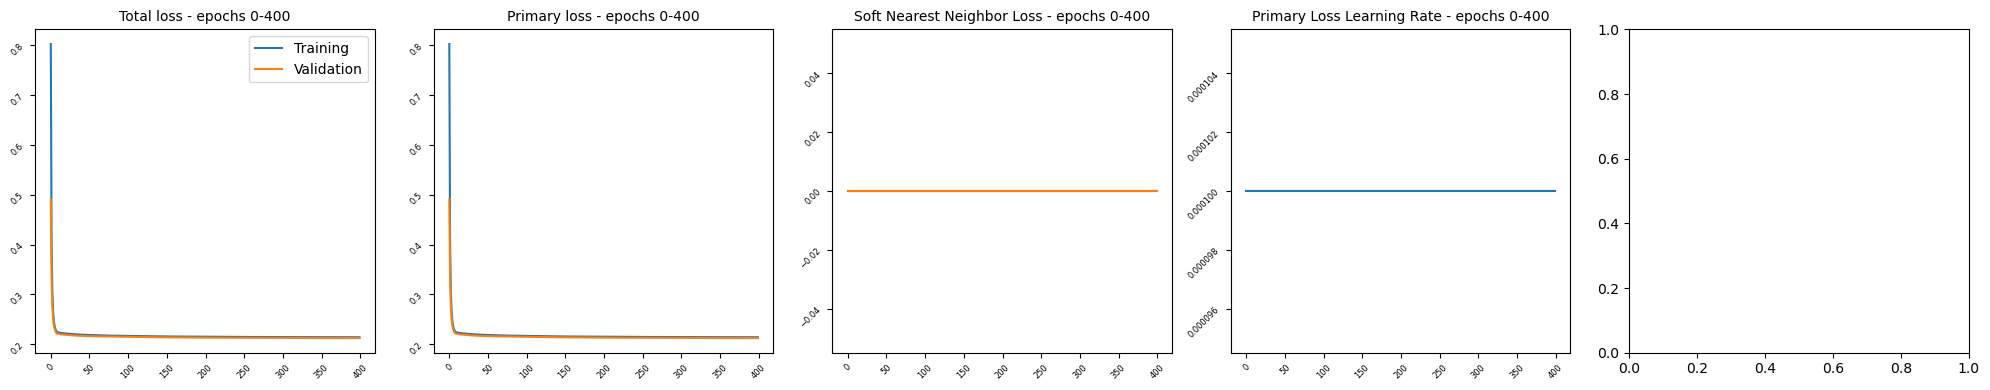

In [29]:
plot_train_history(model, start= 0, n_bins = 25)

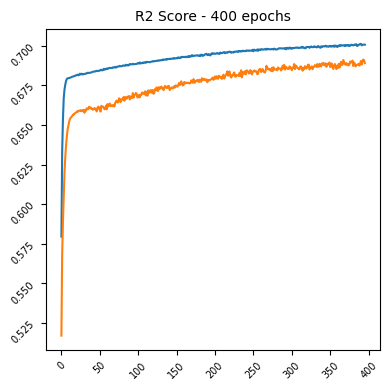

In [30]:
plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= 100, n_bins = 15)

In [ ]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Load model

In [ ]:
# ex_epochs = 200
# ex_mode = 'snnl'
ex_runmode = 'baseline'
ex_date = "20240616"
ex_title="snglOpt-025Ltnt"
# ex_title="secondTry"
# ex_title="dropout04"
# title="autoencoder"
# title='Xentropy'

In [ ]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [ ]:
filename = f"{model.name}_{args.runmode}_{ex_date}_{ex_title}_ep_{ex_epoch:03d}"   
filename = filelist[-1]
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

In [ ]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)
print(model.device)

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()


In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__